# Revisiting Mitch Lewis Data

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
sys.path.insert(0, '../../')
import mut.thermo
import mut.bayes
import mut.stats
import mut.viz
import altair as alt
alt.themes.register('pboc', mut.viz.altair_config)
alt.data_transformers.enable('json')
alt.themes.enable('pboc')
constants = mut.thermo.load_constants()
colors = mut.viz.color_selector('pboc')
mut.viz.plotting_style()
%load_ext stanmagic

In [3]:
# Load the data
data = pd.read_csv('../../data/csv/Daber2011_data.csv')

## Testing the wild-type

There are some experimental differences between the approach we took and what Daber and Lewis did. They relied on expression of the LacI mutants from a plasmid and had yet another plasmid expressing the reporter. This makes things difficult to deal with as we have some variation in copy-number that is not well understood on our end. We can deal with this by fitting the ratio $R / K_{DNA}$ rather than the repressor copy number and DNA binding energy. I know from our work with the induction paper that this doesn't work with our known $K_A$ and $K_I$ from the induction paper, so these parameters will need to be refit. Below I define a stan model which performs inference on these parameters, using the literature value for $\Delta\varepsilon_{AI}$

In [4]:
def pact(c, Ka=139, Ki=0.53, ep_AI=4.5, n_sites=2):
    """Computes the probability of a repressor being active at an inducer concentration c"""
    numer = (1 + c / Ka)**n_sites
    denom = numer + np.exp(-ep_AI) * (1 + c / Ki)**n_sites
    return numer / denom

def fc_rkdna(r_kdna, c, Ka=139, Ki=0.53, ep_AI=4.5, n_sites=2):
    p_act = pact(c, Ka, Ki, ep_AI, n_sites)
    return (1 + r_kdna * p_act)**-1


In [98]:
%%stan -v R_KDNA_model
data {  
    // Dimensional parameters
    int<lower=1> J; // Number of unique mutants
    int<lower=1> N; // Number of unique measurements
    int<lower=1, upper=J> idx[N]; // Identification vector for mutants

    // Allosteric parameters
    vector<lower=0>[N] c; // Inducer concentration in µM
    real ep_AI; // Allosteric energy difference in kBT
    int n_sites; // Number of unique allosteric sites
    
    // Observed parameters
    vector<lower=-0.2, upper=1.2>[N] fc; // Fold-change in gene expression
}

parameters {
    real r_kdna[J];
    real<lower=0> sigma[J];
    real<lower=0> Ka;
    real<lower=0> Ki;

}

transformed parameters {
    real log_ka;
    real log_ki;
    log_ka = log(Ka);
    log_ki = log(Ki);
}

model {
    vector[N] mu;
    vector[N] numer;
    vector[N] denom;
    
    // Define the priors
    r_kdna ~ lognormal(0, 10);
    sigma ~ normal(0, 1);
    log_ka ~ normal(0, 1);
    log_ki ~ normal(0, 1);
    for (i in 1:N) {
        // Compute the pact. 
        numer[i] = (1 + c[i] * exp(-log_ka))^n_sites;
        denom[i] = numer[i] + exp(-ep_AI) * (1 + c[i] * exp(-log_ki))^n_sites;
        
        // Compute the theoretical fold-change
        mu[i] = (1 + (numer[i] / denom[i]) * r_kdna[idx[i]])^-1;
        
        
        // Evaluate the likelihood
        fc[i] ~ normal(mu[i], sigma[idx[i]]);
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in R_KDNA_model object.
Type R_KDNA_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^
Access model compile output properties
R_KDNA_model.model_file -> Name of stan_file [None]
R_KDNA_model.model_name -> Name of stan model [None]
R_KDNA_model.model_code -> Model code [data {       // Dime ....]


In [99]:
# Compile the model
model = pystan.StanModel(model_code=R_KDNA_model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2f43da10dc76ca5f7bebd481d54a89b6 NOW.


In [100]:
# Separate the data and add identifiers. 
DNA_data = data[(data['class']=='WT') | (data['class']=='DNA')].copy()
DNA_idx = {m:i+1 for i, m in enumerate(DNA_data['mutant'].unique())}
for m, i in DNA_idx.items():
    DNA_data.loc[DNA_data['mutant']==m, 'idx'] = i
DNA_data['idx'] = DNA_data['idx'].values.astype(int)

# Assemble the data dictionary. 
data_dict = dict(J=len(DNA_idx), N=len(DNA_data), idx=DNA_data['idx'],
                Ka=constants['Ka'], Ki=constants['Ki'], ep_AI=constants['ep_AI'],
                n_sites=constants['n_sites'], c=DNA_data['IPTGuM'],
                fc=DNA_data['fold_change'])

# Sample the model. 
samples = model.sampling(data_dict, iter=10000, chains=4)

In [106]:
samples_df = mut.bayes.chains_to_dataframe(samples)
# rename the columns 
new_names = {'{}.{}'.format(p, i):'{}.{}'.format(p, m) for m, i in DNA_idx.items() for p in ['r_kdna', 'sigma']}
samples_df.rename(columns=new_names, inplace=True)

# Compute the statistics
stats = mut.stats.compute_statistics(samples_df)

# Compute the fits. 
c_range = np.logspace(-2, 7, 200)
dfs = []
for m, i in DNA_idx.items():
    r_kdna = stats[stats['parameter']=='r_kdna.{}'.format(m)].values[0][1]
    ka = stats[stats['parameter'] == 'Ka'].values[0][1]
    ki = stats[stats['parameter'] == 'Ki'].values[0][1]
    fc_mode = fc_rkdna(r_kdna, c_range, Ka=ka, Ki=ki)
    cred_region = np.zeros([2, len(c_range)])
    for j, c in enumerate(c_range):
        _fc = fc_rkdna(samples_df['r_kdna.{}'.format(m)], c, Ka=samples_df['Ka'], Ki=samples_df['Ki'])
        cred_region[:, j] = mut.stats.compute_hpd(_fc, 0.95)
    # Make the data frame. 
    _df = pd.DataFrame(np.array([c_range, fc_mode, cred_region[0, :], cred_region[1, :]]).T, 
                      columns=['IPTGuM', 'mode', 'min', 'max'])
    _df['mutant'] = m
    dfs.append(_df)
fit_df = pd.concat(dfs)

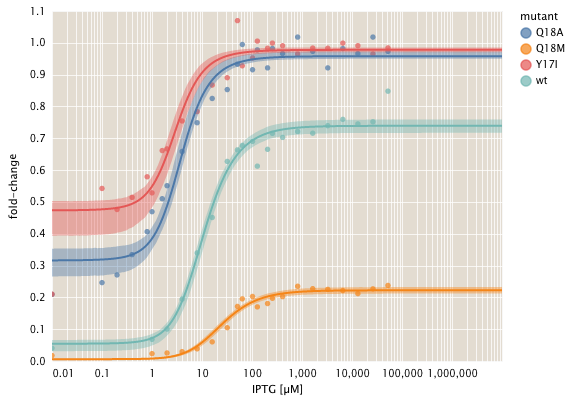

In [107]:
points = alt.Chart(DNA_data, width=450, height=350).mark_point(filled=True).encode(
        x=alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
        y=alt.Y('fold_change:Q', axis={'title':'fold-change'}),
        color='mutant:N').interactive()

modes = alt.Chart(fit_df).mark_line().encode(
        x='IPTGuM:Q',
        y='mode:Q',
        color='mutant:N')

creds = alt.Chart(fit_df).mark_area(opacity=0.4).encode(
        x='IPTGuM:Q',
        y='min:Q', y2='max:Q',
        color='mutant:N')

points + modes + creds

In [109]:
stats

,parameter,mode,hpd_min,hpd_max
0,r_kdna.wt,17.619581,13.354637,29.413027
1,r_kdna.Q18A,2.189444,1.832461,2.766189
2,r_kdna.Q18M,174.843003,130.090306,289.680670
3,r_kdna.Y17I,1.125737,0.987453,1.540340
4,sigma.wt,0.040555,0.027503,0.053931
5,sigma.Q18A,0.049685,0.038191,0.069500
6,sigma.Q18M,0.015666,0.012029,0.023518
7,sigma.Y17I,0.069580,0.051970,0.093438
8,Ka,12.730820,10.655491,15.254040
9,Ki,0.191805,0.137718,0.229935


Okay, this seems to work. Here, I fit a *single* value for $K_A$ and $K_I$ to all of the traces at once and a value of $R \over K_{DNA}$ to each curve individually. Now, we can try to do the opposite with the inducer mutants. 

In [5]:
%%stan -v KAKI_model
data {  
    // Dimensional parameters
    int<lower=1> J; // Number of unique mutants
    int<lower=1> N; // Number of unique measurements
    int<lower=1, upper=J> idx[N]; // Identification vector for mutants

    // Allosteric parameters
    vector<lower=0>[N] c; // Inducer concentration in µM
    real ep_AI; // Allosteric energy difference in kBT
    int n_sites; // Number of unique allosteric sites
    
    // Observed parameters
    vector[N] fc; // Fold-change in gene expression
}

parameters {
    real<lower=0> r_kdna;
    real<lower=0> sigma[J];
    real<lower=0, upper=1E6> Ka[J];
    real<lower=0, upper=1E6> Ki[J];

}

transformed parameters {
    real log_ka[J];
    real log_ki[J];
    log_ka = log(Ka);
    log_ki = log(Ki);
}

model {
    vector[N] mu;
    vector[N] numer;
    vector[N] denom;
    
    // Define the priors
    r_kdna ~ lognormal(0, 2);
    sigma ~ normal(0, 1);
    log_ka ~ normal(0, 1);
    log_ki ~ normal(0, 1);
    for (i in 1:N) {
        // Compute the pact. 
        numer[i] = (1 + c[i] * exp(-log_ka[idx[i]]))^n_sites;
        denom[i] = numer[i] + exp(-ep_AI) * (1 + c[i] * exp(-log_ki[idx[i]]))^n_sites;
        
        // Compute the theoretical fold-change
        mu[i] = (1 + (numer[i] / denom[i]) * r_kdna)^-1;
        
        
        // Evaluate the likelihood
        fc[i] ~ normal(mu[i], sigma[idx[i]]);
    }
}    

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in KAKI_model object.
Type KAKI_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^
Access model compile output properties
KAKI_model.model_file -> Name of stan_file [None]
KAKI_model.model_name -> Name of stan model [None]
KAKI_model.model_code -> Model code [data {       // Dime ....]


In [6]:
# compile the model
kaki_model = pystan.StanModel(model_code=KAKI_model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_84105540e0e8a023c2b4437ef158e120 NOW.


In [15]:
# Parse the data and add identifiers.
IND_data = data[(data['class']=='WT') | (data['class']=='IND')].copy()
IND_idx = {m:i +1 for i, m in enumerate(IND_data['mutant'].unique())}
for m, i in IND_idx.items():
    IND_data.loc[IND_data['mutant']==m, 'idx'] = i
IND_data['idx'] = IND_data['idx'].astype(int)

# Assemble the data dictionary and sample.
data_dict = dict(J=len(IND_idx), N=len(IND_data), idx=IND_data['idx'],
                c=IND_data['IPTGuM'], ep_AI=constants['ep_AI'], n_sites=constants['n_sites'],
                fc=IND_data['fold_change'])
kaki_samples = kaki_model.sampling(data_dict, iter=10000, chains=4)

In [16]:
# Process the dataframe
kaki_df = mut.bayes.chains_to_dataframe(kaki_samples)
# rename the columns 
new_names = {'{}.{}'.format(p, i):'{}.{}'.format(p, m) for m, i in IND_idx.items() for p in ['Ka', 'Ki','sigma']}
kaki_df.rename(columns=new_names, inplace=True)

# Compute the statistics
kaki_stats = mut.stats.compute_statistics(kaki_df)

# Compute the fits. 
c_range = np.logspace(-2, 7, 200)
dfs = []
for m, i in IND_idx.items():
    r_kdna = kaki_stats[kaki_stats['parameter']=='r_kdna'].values[0][1]
    ka = kaki_stats[kaki_stats['parameter'] == 'Ka.{}'.format(m)].values[0][1]
    ki = kaki_stats[kaki_stats['parameter'] == 'Ki.{}'.format(m)].values[0][1]
    fc_mode = fc_rkdna(r_kdna, c_range, Ka=ka, Ki=ki)
    cred_region = np.zeros([2, len(c_range)])
    for j, c in enumerate(c_range):
        _fc = fc_rkdna(kaki_df['r_kdna'], c, Ka=kaki_df['Ka.{}'.format(m)], Ki=kaki_df['Ki.{}'.format(m)])
        cred_region[:, j] = mut.stats.compute_hpd(_fc, 0.95)
    # Make the data frame. 
    _df = pd.DataFrame(np.array([c_range, fc_mode, cred_region[0, :], cred_region[1, :]]).T, 
                      columns=['IPTGuM', 'mode', 'min', 'max'])
    _df['mutant'] = m
    dfs.append(_df)
kaki_fit_df = pd.concat(dfs)

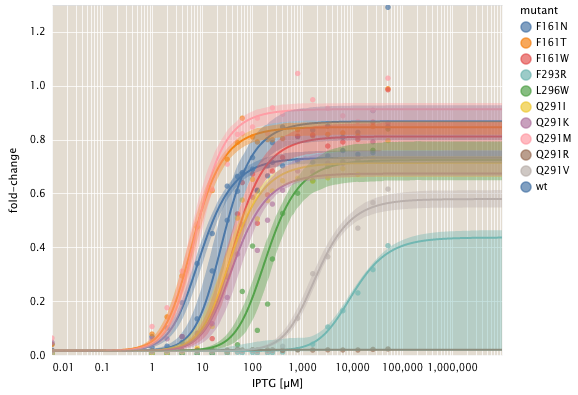

In [17]:
points = alt.Chart(IND_data, width=450, height=350).mark_point(filled=True).encode(
        x=alt.X('IPTGuM:Q', scale={'type':'log'}, axis={'title':'IPTG [µM]'}),
        y=alt.Y('fold_change:Q', axis={'title':'fold-change'}),
        color='mutant:N').interactive()

modes = alt.Chart(kaki_fit_df).mark_line().encode(
        x='IPTGuM:Q',
        y='mode:Q',
        color='mutant:N')

creds = alt.Chart(kaki_fit_df).mark_area(opacity=0.4).encode(
        x='IPTGuM:Q',
        y='min:Q', y2='max:Q',
        color='mutant:N')

points + modes + creds

In [13]:
kaki_stats

,parameter,mode,hpd_min,hpd_max
0,r_kdna,67.732532,57.104592,69.909513
1,sigma.wt,0.038568,0.029921,0.057667
2,sigma.F161N,0.103791,0.079161,0.158205
3,sigma.F161T,0.040964,0.034410,0.066638
4,sigma.F161W,0.069637,0.057216,0.114775
5,sigma.F293R,0.011737,0.008653,0.148102
6,sigma.L296W,0.084828,0.063563,0.126289
7,sigma.Q291I,0.058578,0.042654,0.081359
8,sigma.Q291K,0.073628,0.050998,0.096269
9,sigma.Q291M,0.061032,0.048760,0.098047
